In [2]:
!echo "Last updated:" `date`

Last updated: Wed Jul 22 19:37:29 PDT 2020


# Fitting regular GP in STAN

This notebook demonstrates how a GP is specified and sampled from in STAN.

In [3]:
import pystan
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('../util')
from pystan_vb_extract import pystan_vb_extract
import copy
from scipy.spatial import distance_matrix

In [4]:
# Define GP model.

# See for an explaination of the parameters (rho, alpha) and the convariance function used.
# https://mc-stan.org/docs/2_19/stan-users-guide/gaussian-process-regression.html

gp_model_code = """
data {
    int D;               // number of features (dimensions of X)
    int N;               // number of observations
    vector[N] y;         // response
    matrix[N, D] X;      // predictors
    real<lower=0> eps;   // amount to add to diagonal of covariance function (for numerical stability)
    
    // hyperparameters for GP covariance function range and scale.
    real m_rho;
    real<lower=0> s_rho;
    real m_alpha;
    real<lower=0> s_alpha;
}

transformed data {
    // GP mean function.
    vector[N] mu = rep_vector(0, N);
}

parameters {
    real<lower=0> rho;   // range parameter in GP covariance fn
    real<lower=0> alpha; // covariance scale parameter in GP covariance fn
}

model {
    matrix[N, N] K;   // GP covariance matrix
    matrix[N, N] LK;  // cholesky of GP covariance matrix

    rho ~ lognormal(m_rho, s_rho);  // GP covariance function range parameter
    alpha ~ lognormal(m_alpha, s_alpha);  // GP covariance function scale parameter
   
    // Using exponential quadratic covariance function
    // K(d) = alpha^2 * exp(-0.5 * (d/rho)^2)
    K = cov_exp_quad(to_array_1d(X), alpha, rho); 
    
    // Add small values along diagonal elements for numerical stability.
    for (n in 1:N) {
        K[n, n] = K[n, n] + eps;
    }
        
    // Cholesky of K (lower triangle).
    LK = cholesky_decompose(K);

    // GP likelihood.
    y ~ multi_normal_cholesky(mu, LK);
}
"""

In [5]:
%%time
# Compile model. This takes about a minute.
sm = pystan.StanModel(model_code=gp_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eda81164fce2d216564d967cdfdadbc5 NOW.


CPU times: user 844 ms, sys: 60.6 ms, total: 904 ms
Wall time: 54.2 s


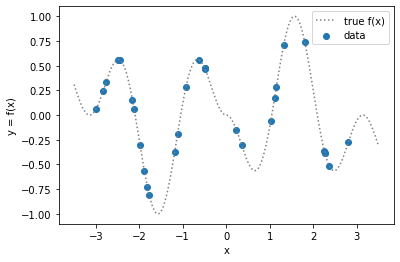

In [6]:
# Read data.
path_to_data = '../data/gp-data-N30.json'
simdata = json.load(open(path_to_data))

# Plot data and true function.
plt.scatter(simdata['x'], simdata['f'], label='data')
plt.plot(simdata['x_true'], simdata['f_true'], ls=':', c='grey', label='true f(x)')
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.legend();

In [7]:
# Data dictionary.
N = len(simdata['x'])
data = dict(y=simdata['f'], X=np.reshape(simdata['x'], (N, 1)), N=N, D=1,
            eps=1e-3, m_rho=-2, s_rho=0.1, m_alpha=0, s_alpha=1)

In [8]:
%%time
# Fit via ADVI.
vb_fit = sm.vb(data=data, iter=2000, seed=2)
vb_samples = pystan_vb_extract(vb_fit)

CPU times: user 161 ms, sys: 46 µs, total: 161 ms
Wall time: 160 ms


In [9]:
%%time
# Fit via HMC
hmc_fit = sm.sampling(data=data, iter=2000, chains=1, warmup=1000, thin=1,
                      seed=1, algorithm='HMC', control=dict(stepsize=0.01, int_time=1))

CPU times: user 1.46 s, sys: 7.56 ms, total: 1.46 s
Wall time: 1.46 s


In [10]:
%%time
# Fit via NUTS
nuts_fit = sm.sampling(data=data, iter=2000, chains=1, warmup=1000, thin=1, seed=1)

CPU times: user 587 ms, sys: 0 ns, total: 587 ms
Wall time: 585 ms


In [11]:
# Covariance function (squared exponential)
def cov_fn(d, rho, alpha):
    return alpha ** 2 * np.exp(-0.5 * (d / rho) ** 2)
    
# Function to create gp prediction function.
def gp_predict_maker(y, x, x_new):
    N = x.shape[0]
    N_new = x_new.shape[0]
    M = N + N_new
    xx = np.concatenate((x_new, x)).reshape(M, 1)
    D = distance_matrix(xx, xx)
    
    # Function which takes parameters of covariance function
    # and predicts at new locations.
    def gp_predict(rho, alpha, eps):
        K = cov_fn(D, rho, alpha) + np.eye(M) * eps
        K_new_old = K[:N_new, N_new:]
        K_old_inv = np.linalg.inv(K[N_new:, N_new:])
        C = K_new_old.dot(K_old_inv)
        mu = C.dot(y)
        S = K[:N_new, :N_new] - C.dot(K_new_old.T)
        return np.random.multivariate_normal(mu, S)
    
    return gp_predict

In [12]:
# Function for plotting parameter posterior.
def plot_post(samples, key, bins=None, suffix=""):
    plt.hist(samples[key], density=True, bins=bins)
    plt.xlabel(key)
    plt.ylabel('density')
    if suffix != "":
        suffix = "({})".format(suffix)
    
    plt.title("{} {}".format(key, suffix));
    
# Function for making all plots.
def make_plots(samples, n_new=100, figsize=(12,4), figsize_f=(12, 4), suffix=""):
    # Create new locations for prediction.
    # But include the data for illustrative purposes.
    x = np.array(simdata['x'])
    y = np.array(simdata['f'])
    x_min = -3.5
    x_max = 3.5
    x_new = np.linspace(x_min, x_max, n_new)
    x_new = np.sort(np.concatenate((x_new, x)))

    # Create gp predict function.
    gp_predict = gp_predict_maker(y, x, x_new)

    # Number of posterior samples.
    nsamples = len(samples['alpha'])

    # Make predictions at new locations.
    preds = np.stack([gp_predict(alpha=samples['alpha'][b],
                                 rho=samples['rho'][b],
                                 eps=data['eps'])
                      for b in range(nsamples)])
      
    # Plot parameters posterior.
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plot_post(samples, 'alpha', bins=30, suffix=suffix)
    plt.subplot(1, 2, 2)
    plot_post(samples, 'rho', bins=30, suffix=suffix)
    
    # Summarize function posterior.
    preds_mean = preds.mean(0)
    preds_lower = np.percentile(preds, 2.5, axis=0)
    preds_upper = np.percentile(preds, 97.5, axis=0)
    
    # Make suffix
    if suffix != "":
        suffix = "({})".format(suffix)

    # Plot function posterior.
    plt.figure(figsize=figsize_f)
    plt.scatter(x, y, c='black', zorder=3, label='data')
    plt.fill_between(x_new, preds_upper, preds_lower, alpha=.3, label='95% CI');
    plt.plot(x_new, preds.mean(0), lw=2, label="mean fn.")
    plt.plot(simdata['x_true'], simdata['f_true'], label="truth", lw=2, c='red', ls=':')
    plt.title("GP Posterior Predictive with 95% CI {}".format(suffix))
    plt.legend(); 

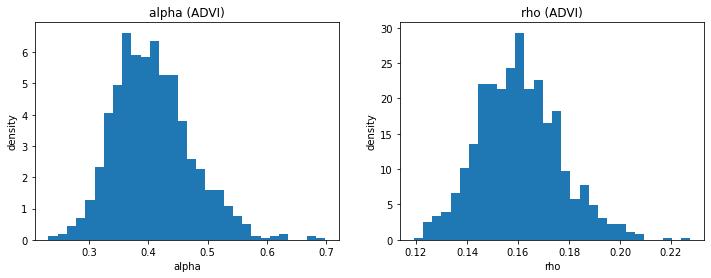

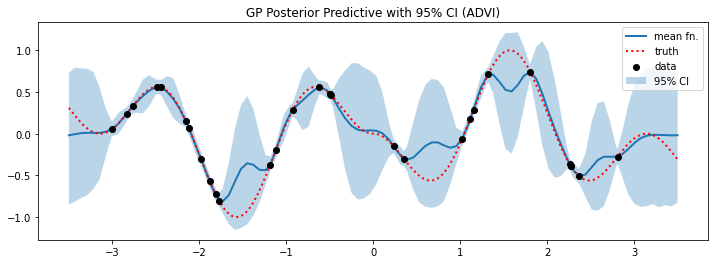

In [13]:
make_plots(vb_samples, suffix="ADVI")

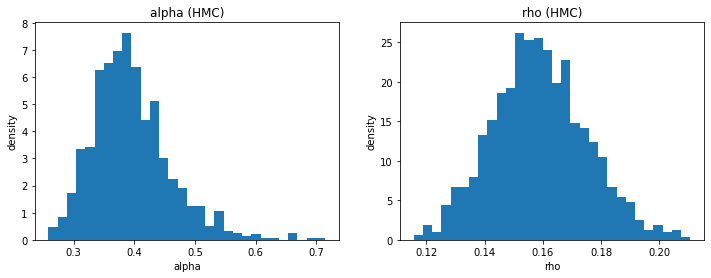

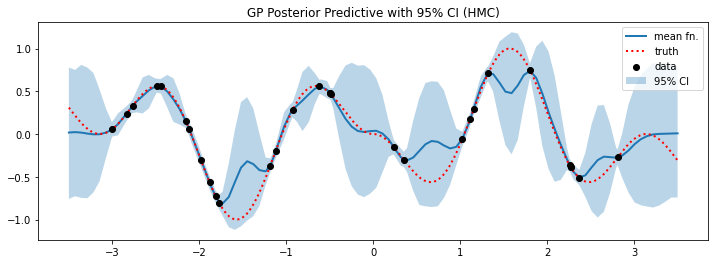

In [14]:
make_plots(hmc_fit, suffix="HMC")

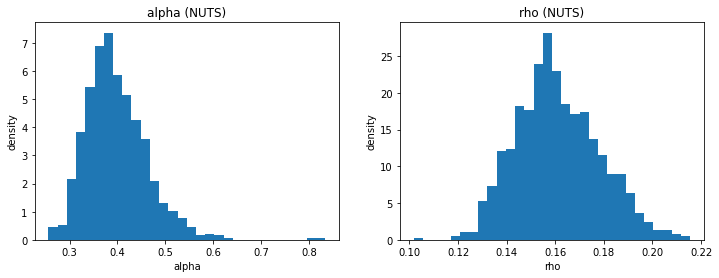

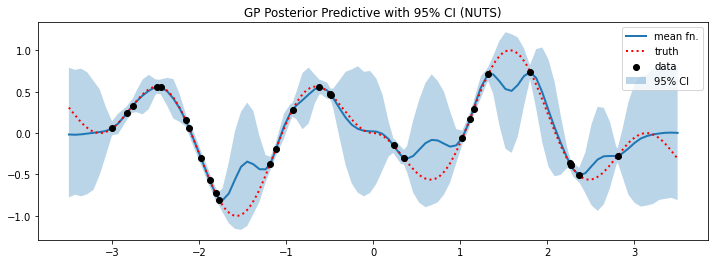

In [15]:
make_plots(nuts_fit, suffix="NUTS")